In [186]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, IBMQ
from qiskit.quantum_info import random_statevector, Statevector
from numpy import pi
from qiskit.tools.monitor import job_monitor
#IBMQ.enable_account('9ca92f99294968c8d883deea6f397c27fd7e904601a7fee44f61a0a525f10d25dbbdf6487fc5be871e59002f8f23045845f3693f35f130a1ac6ff8e84630c607')

from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
backend = AerSimulator()
from qiskit.visualization import plot_histogram
import random

In [187]:
# set random vector
random_vector = random_statevector(2)
random_vector.draw('latex')

<IPython.core.display.Latex object>

In [188]:
print("Is random_vector normalized ? "+ str(random_vector.is_valid()))
p_0 = round(random_vector.probabilities()[0]*100,2)
p_1 = round(random_vector.probabilities()[1]*100,2)
print("P(M(q=0))="+str(p_0)+"%")
print("P(M(q=1))="+str(p_1)+"%")

Is random_vector normalized ? True
P(M(q=0))=26.98%
P(M(q=1))=73.02%


In [189]:
chosen_lines = []
chosen_errors = []
results = []
errors = ["X", "Z", "XZ"]

for line in range(9):
    for e in range(3):
        # Define Quantum Registers for circuit"
        q_input = QuantumRegister(1, 'variable')
        q = QuantumRegister(8, "q_")
        a = QuantumRegister(8, "a")
        c = ClassicalRegister(8, 'c')
        circ = QuantumCircuit(q[:4], q_input, q[4:], a, c)

        # Define a method to fastly use barrier :
        def barrier():
            circ.barrier(q[:4],q_input,q[4:],a)

        # Initialized qubit 4 with the previously random vector :
        circ.initialize(random_vector,4)

        # Circuit implementation :
        circ.cx(q_input[0], q[6])
        circ.cx(q_input[0], q[1])
        barrier()
        circ.h(q[1])
        circ.h(q_input[0])
        circ.h(q[6])
        circ.cx(q[1], q[2])
        circ.cx(q_input[0], q[4])
        circ.cx(q[6], q[7])
        circ.cx(q[1], q[0])
        circ.cx(q_input[0], q[3])
        circ.cx(q[6], q[5])
        barrier()

        # Add error for the qubit i :
        error = errors[e]
        if error=="X":
            circ.x(line)
        if error=="Z":
            circ.z(line)
        if error=="XZ":
            circ.x(line)
            circ.z(line)
        barrier()

        # Hadamard gates on Ancilla qubits
        for x in a:
            circ.h(x)

        circ.cz(q[7],a[7])
        circ.cz(q[6],a[7])
        barrier()
        circ.cz(q[4],a[5])
        circ.cz(q_input[0],a[5])
        barrier()
        circ.cz(q[2],a[3])
        circ.cz(q[1],a[3])
        barrier()
        circ.cz(q[6],a[6])
        circ.cz(q[5],a[6])
        barrier()
        circ.cz(q_input[0],a[4])
        circ.cz(q[3],a[4])
        barrier()
        circ.cz(q[1],a[2])
        circ.cz(q[0],a[2])
        barrier()
        for i in range(3,9):
            circ.cx(a[1], i)
        barrier()
        for i in range(0,6):
            circ.cx(a[0], i)
        barrier()
        for i in range(8) :
            circ.h(a[i])
            circ.measure(a[i],c[i])
        barrier()

        # Uncomment the following line to save circuits as image
        #circ.draw('mpl', filename="./circuits/error_Q"+str(line)+"_"+str(error))
        # Display measurements of ancilla qubits for 1024 shots
        shots = 1000
        qc_compiled = transpile(circ, backend)
        job_sim = backend.run(qc_compiled, shots=shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(qc_compiled)
        #print("Are ancilla measurements all the same ? " + str(len(counts)==1))

        ancilla = max(counts)

        chosen_lines.append(line)
        chosen_errors.append(error)
        results.append(ancilla)
        #print(results)    

In [190]:
from tabulate import tabulate
data = []
for j in range(len(results)):
    data.append([chosen_lines[j],chosen_errors[j], results[j]])
print(tabulate(data, headers=["Line", "Error", "Ancilla"]))

  Line  Error      Ancilla
------  -------  ---------
     0  X         00000100
     0  Z         00000001
     0  XZ        00000101
     1  X         00001100
     1  Z         00000001
     1  XZ        00001101
     2  X         00001000
     2  Z         00000001
     2  XZ        00001001
     3  X         00010000
     3  Z         00000011
     3  XZ        00010011
     4  X         00110000
     4  Z         00000011
     4  XZ        00110011
     5  X         00100000
     5  Z         00000011
     5  XZ        00100011
     6  X         01000000
     6  Z         00000010
     6  XZ        01000010
     7  X         11000000
     7  Z         00000010
     7  XZ        11000010
     8  X         10000000
     8  Z         00000010
     8  XZ        10000010


In [191]:
ancilla_dict = {}
for index in range(len(results)):
    ancilla_dict[results[index]] = {"line":chosen_lines[index], "error": chosen_errors[index]}

print(ancilla_dict)

{'00000100': {'line': 0, 'error': 'X'}, '00000001': {'line': 2, 'error': 'Z'}, '00000101': {'line': 0, 'error': 'XZ'}, '00001100': {'line': 1, 'error': 'X'}, '00001101': {'line': 1, 'error': 'XZ'}, '00001000': {'line': 2, 'error': 'X'}, '00001001': {'line': 2, 'error': 'XZ'}, '00010000': {'line': 3, 'error': 'X'}, '00000011': {'line': 5, 'error': 'Z'}, '00010011': {'line': 3, 'error': 'XZ'}, '00110000': {'line': 4, 'error': 'X'}, '00110011': {'line': 4, 'error': 'XZ'}, '00100000': {'line': 5, 'error': 'X'}, '00100011': {'line': 5, 'error': 'XZ'}, '01000000': {'line': 6, 'error': 'X'}, '00000010': {'line': 8, 'error': 'Z'}, '01000010': {'line': 6, 'error': 'XZ'}, '11000000': {'line': 7, 'error': 'X'}, '11000010': {'line': 7, 'error': 'XZ'}, '10000000': {'line': 8, 'error': 'X'}, '10000010': {'line': 8, 'error': 'XZ'}}


Introduced a Z error on qubit 7


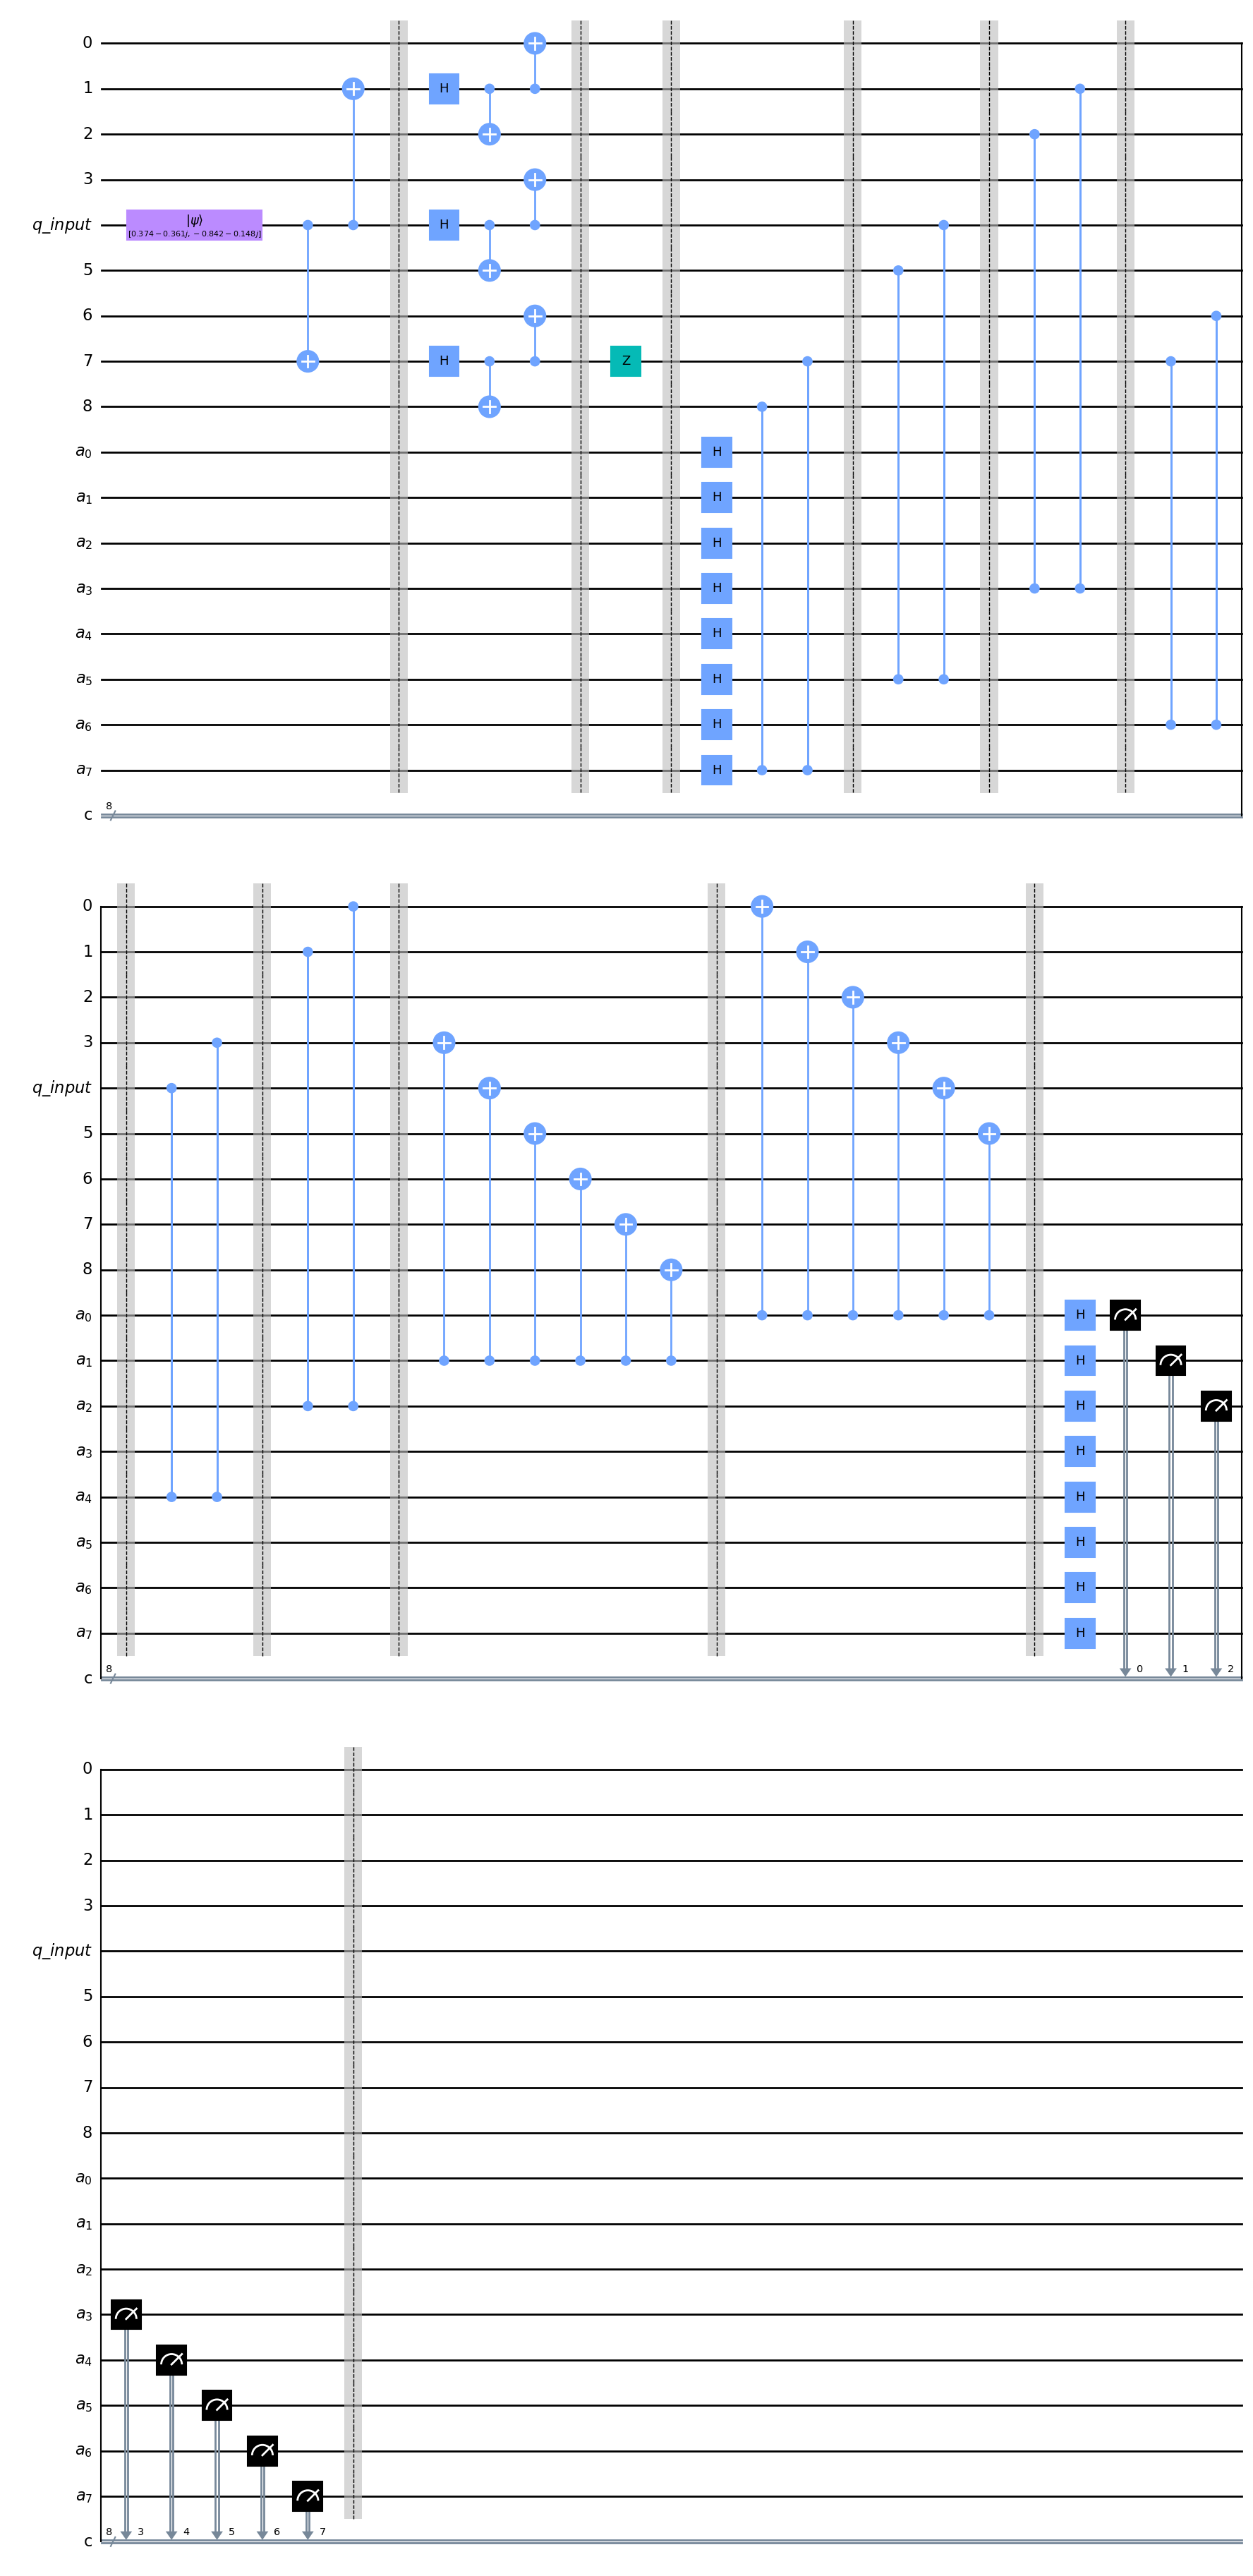

In [192]:
# Define Quantum Registers for circuit"
q_input = QuantumRegister(1, 'q_input')
q = QuantumRegister(8, "q")
a = QuantumRegister(8, "a")
c = ClassicalRegister(8, 'c')
circ = QuantumCircuit(q[:4], q_input, q[4:], a, c)

# Define a method to fastly use barrier :
def barrier():
    circ.barrier(q[:4],q_input,q[4:],a)

# Initialized qubit 4 with the previously random vector :
circ.initialize(random_vector,4)

# Circuit implementation :
circ.cx(q_input[0], q[6])
circ.cx(q_input[0], q[1])
barrier()
circ.h(q[1])
circ.h(q_input[0])
circ.h(q[6])
circ.cx(q[1], q[2])
circ.cx(q_input[0], q[4])
circ.cx(q[6], q[7])
circ.cx(q[1], q[0])
circ.cx(q_input[0], q[3])
circ.cx(q[6], q[5])
barrier()

# Chose random qubit to put an error on :
random_q = random.randint(0,8)

errors = ["X", "Z", "XZ"]
# Chose a random error type for the qubit 0 :
error = errors[random.randint(0,2)]
if error=="X":
    circ.x(random_q)
    print("Introduced a X error on qubit "+str(random_q))
if error=="Z":
    circ.z(random_q)
    print("Introduced a Z error on qubit "+str(random_q))
if error=="XZ":
    circ.x(random_q)
    circ.z(random_q)
    print("Introduced a XZ error on qubit "+str(random_q))
barrier()

# Hadamard gates on Ancilla qubits
for x in a:
    circ.h(x)

circ.cz(q[7],a[7])
circ.cz(q[6],a[7])
barrier()
circ.cz(q[4],a[5])
circ.cz(q_input[0],a[5])
barrier()
circ.cz(q[2],a[3])
circ.cz(q[1],a[3])
barrier()
circ.cz(q[6],a[6])
circ.cz(q[5],a[6])
barrier()
circ.cz(q_input[0],a[4])
circ.cz(q[3],a[4])
barrier()
circ.cz(q[1],a[2])
circ.cz(q[0],a[2])
barrier()
for i in range(3,9):
    circ.cx(a[1], i)
barrier()
for i in range(0,6):
    circ.cx(a[0], i)
barrier()
for i in range(8) :
    circ.h(a[i])
    circ.measure(a[i],c[i])
barrier()

circ.draw('mpl')

{'00000010': 1024}


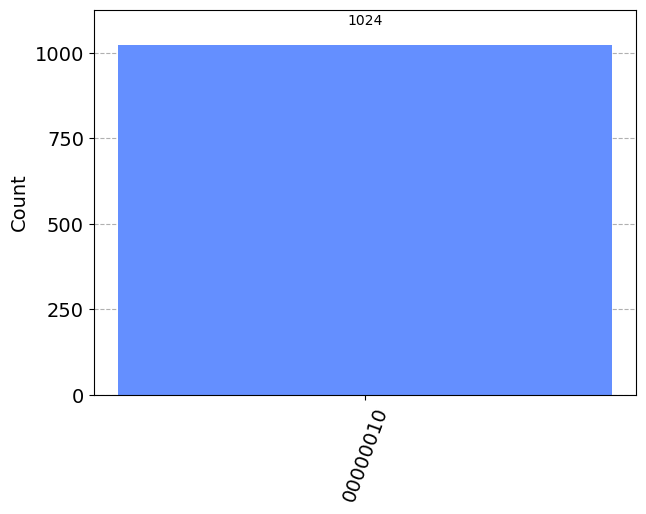

In [193]:
# Display measurements of ancilla qubits for 1024 shots

qc_compiled = transpile(circ, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)
plot_histogram(counts)

ancilla =  00000010
It was a Z error on line 8


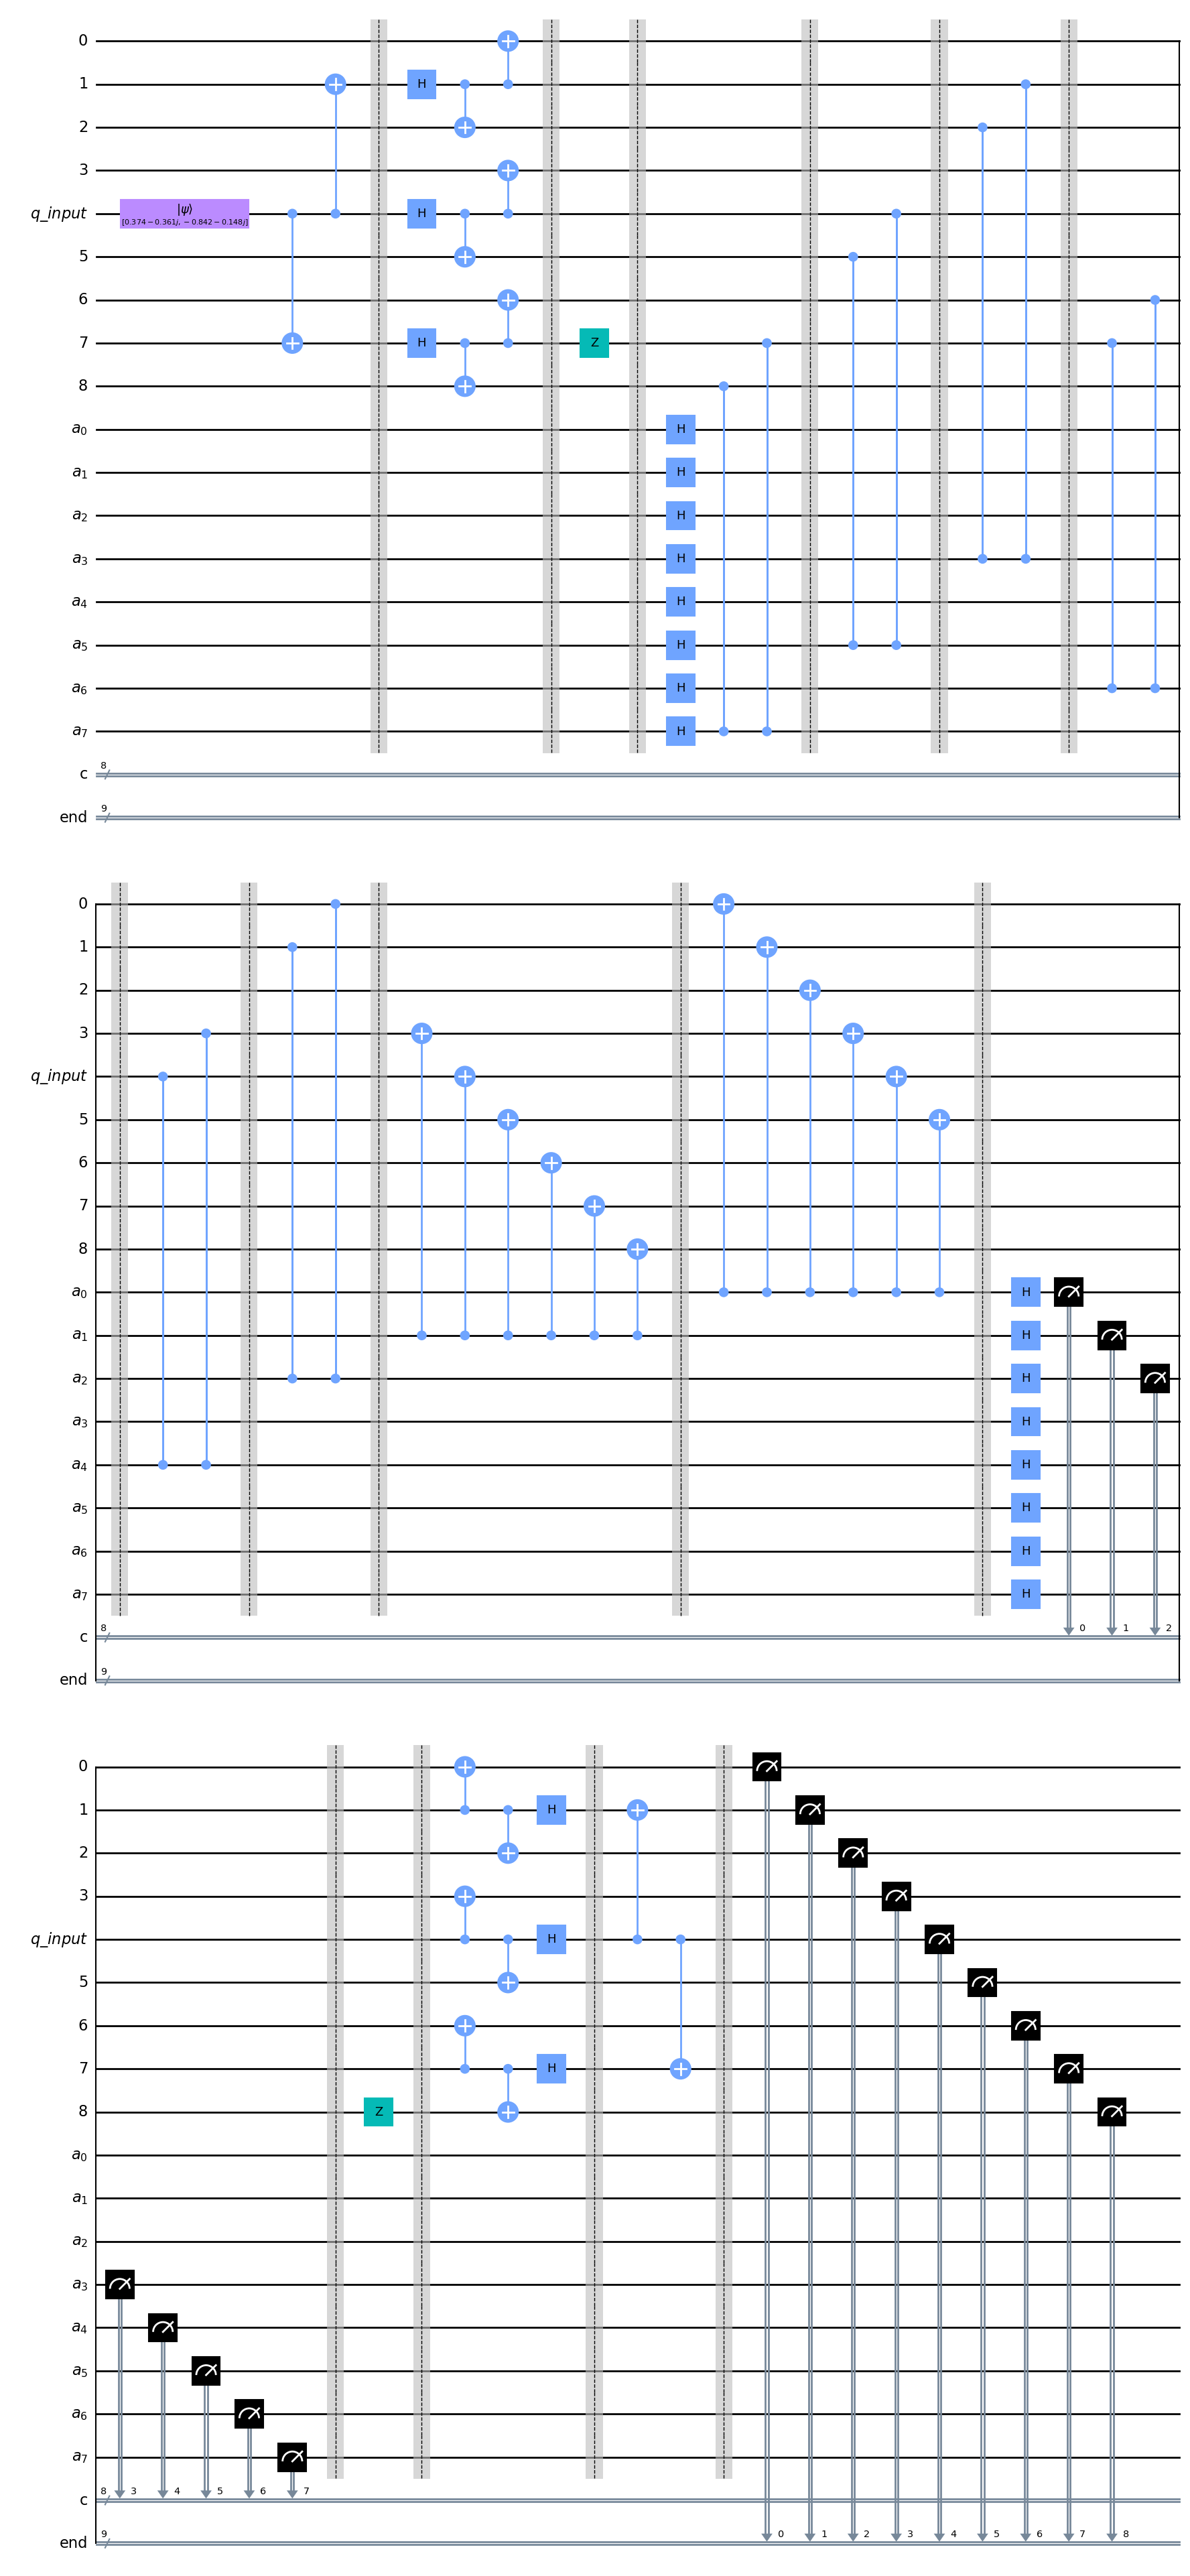

In [194]:
ancilla = max(counts)
print("ancilla = ", ancilla)

# Add a new Classical Register to get measurements of the 9 qubits
c_end = ClassicalRegister(9, 'end')

# Correct state according to the error :
# Used our ancilla results dict :
for combination in ancilla_dict.keys():
    if(ancilla==combination):
        line = ancilla_dict[combination]["line"]
        error = ancilla_dict[combination]["error"]
        #Apply error correction
        print("It was a "+str(error)+" error on line "+str(line))
        if(error=="X"):
            circ.x(int(line))
        if(error=="Z"):
            circ.z(int(line))
        if(error=="X"):
            circ.x(int(line))
            circ.z(int(line))


barrier()
circ.cx(q[1], q[0])
circ.cx(q_input[0], q[3])
circ.cx(q[6], q[5])
circ.cx(q[1], q[2])
circ.cx(q_input[0], q[4])
circ.cx(q[6], q[7])
circ.h(q[1])
circ.h(q_input[0])
circ.h(q[6])
barrier()
circ.cx(q_input[0], q[1])
circ.cx(q_input[0], q[6])
barrier()
circ.add_register(c_end)
for i in range(9) :
    circ.measure(i,c_end[i])



circ.draw('mpl')